# Comparative Analysis of Machine Learning Models 

As a risk department of an insurance company, we understand the importance of building robust predictive models to accurately assess the likelihood of claims for various insurance products. In our quest to build a better model for predicting car insurance claims within the first 6 months of insurance, we have explored multiple machine learning algorithms and techniques.

This notebook presents a detailed analysis of the different models we have tried, including their strengths and weaknesses, and how they compare to our baseline model. We have experimented with various algorithms such as decision trees, random forests, logistic regression, and support vector machines, among others.

Our aim is to identify the best-performing model that can help us make more accurate predictions, minimize potential losses, and ensure the stability of our cash flows. By evaluating the models based on various metrics such as AUC-ROC, precision, recall, and F1-score, we can determine which model is best suited for our specific use case.

With this information, we can make data-driven decisions that can help us manage risks effectively and offer competitive prices to our customers while maintaining profitability. The second notebook serves as a comprehensive guide to our model selection process, providing insights that can be leveraged to improve our existing models and build more robust predictive models in the future.

## Model 1: Logistic Regression:

## Model 2: MLP Classifier

In [5]:
# Creating a custom MLPDropout classifier
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network._stochastic_optimizers import AdamOptimizer
from sklearn.neural_network._base import ACTIVATIONS, DERIVATIVES, LOSS_FUNCTIONS
from sklearn.utils import shuffle, gen_batches, check_random_state, _safe_indexing
from sklearn.utils.extmath import safe_sparse_dot
import warnings
from sklearn.exceptions import ConvergenceWarning

class MLPDropout(MLPClassifier):
    
    def __init__(
        self,
        hidden_layer_sizes=(100,),
        activation="relu",
        *,
        solver="adam",
        alpha=0.0001,
        batch_size="auto",
        learning_rate="constant",
        learning_rate_init=0.001,
        power_t=0.5,
        max_iter=200,
        shuffle=True,
        random_state=None,
        tol=1e-4,
        verbose=False,
        warm_start=False,
        momentum=0.9,
        nesterovs_momentum=True,
        early_stopping=False,
        validation_fraction=0.1,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-8,
        n_iter_no_change=10,
        max_fun=15000,
        dropout = None,
    ):
        '''
        Additional Parameters:
        ----------
        dropout : float in range (0, 1), default=None
            Dropout parameter for the model, defines the percentage of nodes
            to remove at each layer.
            
        '''
        self.dropout = dropout
        super().__init__(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            solver=solver,
            alpha=alpha,
            batch_size=batch_size,
            learning_rate=learning_rate,
            learning_rate_init=learning_rate_init,
            power_t=power_t,
            max_iter=max_iter,
            shuffle=shuffle,
            random_state=random_state,
            tol=tol,
            verbose=verbose,
            warm_start=warm_start,
            momentum=momentum,
            nesterovs_momentum=nesterovs_momentum,
            early_stopping=early_stopping,
            validation_fraction=validation_fraction,
            beta_1=beta_1,
            beta_2=beta_2,
            epsilon=epsilon,
            n_iter_no_change=n_iter_no_change,
            max_fun=max_fun,
        )
    
    def _fit_stochastic(
        self,
        X,
        y,
        activations,
        deltas,
        coef_grads,
        intercept_grads,
        layer_units,
        incremental,
    ):
        params = self.coefs_ + self.intercepts_
        if not incremental or not hasattr(self, "_optimizer"):
            if self.solver == "sgd":
                self._optimizer = SGDOptimizer(
                    params,
                    self.learning_rate_init,
                    self.learning_rate,
                    self.momentum,
                    self.nesterovs_momentum,
                    self.power_t,
                )
            elif self.solver == "adam":
                self._optimizer = AdamOptimizer(
                    params,
                    self.learning_rate_init,
                    self.beta_1,
                    self.beta_2,
                    self.epsilon,
                )

        # early_stopping in partial_fit doesn't make sense
        early_stopping = self.early_stopping and not incremental
        if early_stopping:
            # don't stratify in multilabel classification
            should_stratify = is_classifier(self) and self.n_outputs_ == 1
            stratify = y if should_stratify else None
            X, X_val, y, y_val = train_test_split(
                X,
                y,
                random_state=self._random_state,
                test_size=self.validation_fraction,
                stratify=stratify,
            )
            if is_classifier(self):
                y_val = self._label_binarizer.inverse_transform(y_val)
        else:
            X_val = None
            y_val = None

        n_samples = X.shape[0]
        sample_idx = np.arange(n_samples, dtype=int)

        if self.batch_size == "auto":
            batch_size = min(200, n_samples)
        else:
            if self.batch_size < 1 or self.batch_size > n_samples:
                warnings.warn(
                    "Got `batch_size` less than 1 or larger than "
                    "sample size. It is going to be clipped"
                )
            batch_size = np.clip(self.batch_size, 1, n_samples)

        try:
            for it in range(self.max_iter):
                if self.shuffle:
                    # Only shuffle the sample indices instead of X and y to
                    # reduce the memory footprint. These indices will be used
                    # to slice the X and y.
                    sample_idx = shuffle(sample_idx, random_state=self._random_state)

                accumulated_loss = 0.0
                for batch_slice in gen_batches(n_samples, batch_size):
                    if self.shuffle:
                        X_batch = _safe_indexing(X, sample_idx[batch_slice])
                        y_batch = y[sample_idx[batch_slice]]
                    else:
                        X_batch = X[batch_slice]
                        y_batch = y[batch_slice]
                    
                    activations[0] = X_batch
                    # (DROPOUT ADDITION) layer_units passed forward to help build dropout mask.
                    batch_loss, coef_grads, intercept_grads = self._backprop(
                        X_batch,
                        y_batch,
                        activations,
                        layer_units,
                        deltas,
                        coef_grads,
                        intercept_grads,
                    )
                    accumulated_loss += batch_loss * (
                        batch_slice.stop - batch_slice.start
                    )

                    # update weights
                    grads = coef_grads + intercept_grads
                    self._optimizer.update_params(params, grads)

                self.n_iter_ += 1
                self.loss_ = accumulated_loss / X.shape[0]

                self.t_ += n_samples
                self.loss_curve_.append(self.loss_)
                if self.verbose:
                    print("Iteration %d, loss = %.8f" % (self.n_iter_, self.loss_))

                # update no_improvement_count based on training loss or
                # validation score according to early_stopping
                self._update_no_improvement_count(early_stopping, X_val, y_val)

                # for learning rate that needs to be updated at iteration end
                self._optimizer.iteration_ends(self.t_)

                if self._no_improvement_count > self.n_iter_no_change:
                    # not better than last `n_iter_no_change` iterations by tol
                    # stop or decrease learning rate
                    if early_stopping:
                        msg = (
                            "Validation score did not improve more than "
                            "tol=%f for %d consecutive epochs."
                            % (self.tol, self.n_iter_no_change)
                        )
                    else:
                        msg = (
                            "Training loss did not improve more than tol=%f"
                            " for %d consecutive epochs."
                            % (self.tol, self.n_iter_no_change)
                        )

                    is_stopping = self._optimizer.trigger_stopping(msg, self.verbose)
                    if is_stopping:
                        break
                    else:
                        self._no_improvement_count = 0

                if incremental:
                    break

                if self.n_iter_ == self.max_iter:
                    warnings.warn(
                        "Stochastic Optimizer: Maximum iterations (%d) "
                        "reached and the optimization hasn't converged yet."
                        % self.max_iter,
                        ConvergenceWarning,
                    )
        except KeyboardInterrupt:
            warnings.warn("Training interrupted by user.")

        if early_stopping:
            # restore best weights
            self.coefs_ = self._best_coefs
            self.intercepts_ = self._best_intercepts
    
    def _backprop(self, X, y, activations, layer_units, deltas, coef_grads, intercept_grads):
        """Compute the MLP loss function and its corresponding derivatives
        with respect to each parameter: weights and bias vectors.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The input data.

        y : ndarray of shape (n_samples,)
            The target values.

        activations : list, length = n_layers - 1
            The ith element of the list holds the values of the ith layer.
             
        layer_units (DROPOUT ADDITION) : list, length = n_layers
            The layer units of the neural net, this is the shape of the
            Neural Net model. This is used to build the dropout mask.

        deltas : list, length = n_layers - 1
            The ith element of the list holds the difference between the
            activations of the i + 1 layer and the backpropagated error.
            More specifically, deltas are gradients of loss with respect to z
            in each layer, where z = wx + b is the value of a particular layer
            before passing through the activation function

        coef_grads : list, length = n_layers - 1
            The ith element contains the amount of change used to update the
            coefficient parameters of the ith layer in an iteration.

        intercept_grads : list, length = n_layers - 1
            The ith element contains the amount of change used to update the
            intercept parameters of the ith layer in an iteration.

        Returns
        -------
        loss : float
        coef_grads : list, length = n_layers - 1
        intercept_grads : list, length = n_layers - 1
        """
        n_samples = X.shape[0]
        dropout_masks = None
        
        # Create the Dropout Mask (DROPOUT ADDITION)
        if self.dropout != None:
            if 0 < self.dropout < 1:
                keep_probability = 1 - self.dropout
                dropout_masks = [np.ones(layer_units[0])]
                
                # Create hidden Layer Dropout Masks
                for units in layer_units[1:-1]:
                    # Create inverted Dropout Mask, check for random_state
                    if self.random_state != None:
                        layer_mask = (self._random_state.random(units) < keep_probability).astype(int) / keep_probability
                    else:
                        layer_mask = (np.random.rand(units) < keep_probability).astype(int) / keep_probability
                    dropout_masks.append(layer_mask)
            else:
                raise ValueError('Dropout must be between zero and one. If Dropout=X then, 0 < X < 1.')
        
        # Forward propagate
        # Added dropout_makss to _forward_pass call (DROPOUT ADDITION)
        activations = self._forward_pass(activations, dropout_masks)
        
        # Get loss
        loss_func_name = self.loss
        if loss_func_name == "log_loss" and self.out_activation_ == "logistic":
            loss_func_name = "binary_log_loss"
        loss = LOSS_FUNCTIONS[loss_func_name](y, activations[-1])
        # Add L2 regularization term to loss
        values = 0
        for s in self.coefs_:
            s = s.ravel()
            values += np.dot(s, s)
        loss += (0.5 * self.alpha) * values / n_samples

        # Backward propagate
        last = self.n_layers_ - 2

        # The calculation of delta[last] here works with following
        # combinations of output activation and loss function:
        # sigmoid and binary cross entropy, softmax and categorical cross
        # entropy, and identity with squared loss
        deltas[last] = activations[-1] - y
        
        # Compute gradient for the last layer
        self._compute_loss_grad(
            last, n_samples, activations, deltas, coef_grads, intercept_grads
        )

        inplace_derivative = DERIVATIVES[self.activation]
        # Iterate over the hidden layers
        for i in range(self.n_layers_ - 2, 0, -1):
            deltas[i - 1] = safe_sparse_dot(deltas[i], self.coefs_[i].T)
            inplace_derivative(activations[i], deltas[i - 1])
            
            self._compute_loss_grad(
                i - 1, n_samples, activations, deltas, coef_grads, intercept_grads
            )
        
        # Apply Dropout Masks to the Parameter Gradients (DROPOUT ADDITION)
        if dropout_masks != None:
            for layer in range(len(coef_grads)-1):
                mask = (~(dropout_masks[layer+1] == 0)).astype(int)
                coef_grads[layer] = coef_grads[layer] * mask[None, :]
                coef_grads[layer+1] = (coef_grads[layer+1] * mask.reshape(-1, 1))
                intercept_grads[layer] = intercept_grads[layer] * mask
        
        return loss, coef_grads, intercept_grads
    
    def _forward_pass(self, activations, dropout_masks=None):
        """Perform a forward pass on the network by computing the values
        of the neurons in the hidden layers and the output layer.

        Parameters
        ----------
        activations : list, length = n_layers - 1
            The ith element of the list holds the values of the ith layer.
        dropout_mask : list, length = n_layers - 1
            The ith element of the list holds the dropout mask for the ith
            layer.
        """
        hidden_activation = ACTIVATIONS[self.activation]
        # Iterate over the hidden layers
        for i in range(self.n_layers_ - 1):
            activations[i + 1] = safe_sparse_dot(activations[i], self.coefs_[i])
            activations[i + 1] += self.intercepts_[i]
            
            # For the hidden layers
            if (i + 1) != (self.n_layers_ - 1):
                hidden_activation(activations[i + 1])
            
            # Apply Dropout Mask (DROPOUT ADDITION)
            if (i + 1) != (self.n_layers_ - 1) and dropout_masks != None:
                check1 = activations[i].copy()
                activations[i+1] = activations[i+1] * dropout_masks[i+1][None, :]

        # For the last layer
        output_activation = ACTIVATIONS[self.out_activation_]
        output_activation(activations[i + 1])
        return activations



Optimal threshold: 0.07
Accuracy: 53.73%
Precision: 9.52%
Recall: 72.62%
ROC-AUC: 62.52%
F1 score: 16.84% 




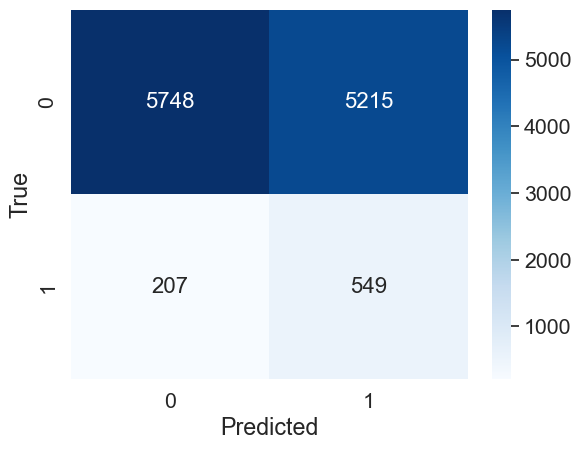

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import BaggingClassifier

import warnings
warnings.filterwarnings('ignore')

# Load cleaned dataset
df = pd.read_csv('Deep_learning/ml_gw_car_insurance_cleaned.csv')

# Split data into features and target variable
X = df.drop('is_claim', axis=1)
y = df['is_claim']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build neural network
model = MLPDropout(hidden_layer_sizes=(20, 10, 5), dropout=0.015, alpha=1e-07, max_iter=300, solver='adam', activation='tanh', learning_rate='invscaling', random_state=42)

# Train the ensemble model on the training data
model.fit(X_train, y_train)

# Evaluate model on test set
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Make predictions with optimal threshold
y_pred = (y_pred_proba >= optimal_threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print results
print('\n\nOptimal threshold: %.2f' % optimal_threshold)
print('Accuracy: %.2f%%' % (accuracy * 100))
print('Precision: %.2f%%' % (precision * 100))
print('Recall: %.2f%%' % (recall * 100))
print('ROC-AUC: %.2f%%' % round((roc_auc * 100), 2))
print('F1 score: %.2f%%' % (f1 * 100), '\n\n')


# Visualize confusion matrix
sns.set(font_scale=1.4)  # for label size
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Rationale Deep Learning Model

Deep learning models have become increasingly popular in the insurance industry due to their ability to handle large amounts of data and make accurate predictions. These models have been particularly useful in predicting insurance claims, where accuracy is crucial in order to minimize costs for insurance companies.

One common application of deep learning in insurance is the analysis of claims data to identify patterns and trends. This allows insurers to gain insights into the types of claims being made and the factors that contribute to these claims, enabling them to develop more effective risk management strategies.Deep learning models can also be used to predict the likelihood of future claims, based on a range of factors such as previous claims history, demographic information, and other relevant data. This allows insurers to take proactive measures to prevent claims from occurring or to manage them more effectively when they do occur.

Overall, deep learning models have significant potential to transform the insurance industry by improving accuracy, reducing costs, and enhancing the customer experience. As the technology continues to advance, we can expect to see even more innovative applications of deep learning in insurance in the years to come.

### Chosen Metric

Insurance companies want to maximize recall in their prediction models because it is better to be cautious and identify all potential risks or claims even if it means a higher false positive rate. False positives may result in higher costs due to investigating claims that turn out to be false, but false negatives can be much more costly for insurance companies as they miss out on potential premiums, and may lead to customers being dissatisfied with the company's services. Therefore, maximizing recall ensures that the insurance company is identifying as many potential claims as possible and minimizing the risk of missing out on potential premium revenue.

### Hyperparameter tuning

To build a deep learning model with optimal hyperparameters, GridSearchCV was used. GridSearchCV is a method of tuning hyperparameters for a model that exhaustively searches over a specified parameter grid to find the best hyperparameters for the model. In this case, the model used is a multilayer perceptron (MLP) neural network with dropout regularization. The MLP has three hidden layers with 20, 10, and 5 neurons respectively. The activation function used is hyperbolic tangent (tanh) and the optimizer is Adam. The learning rate is invscaling, and the random seed is set to 42.

To perform GridSearchCV, a parameter grid was defined with several hyperparameters and their possible values. The hyperparameters included the size of the hidden layers, the activation function, the optimizer, the maximum number of iterations, and the regularization parameter alpha. GridSearchCV was performed with 5-fold cross-validation and recall was used as the scoring metric. After performing the search, the best hyperparameters were printed, and the model was retrained with the best hyperparameters. The resulting model was the best performing one in terms of recall and was optimized using the hyperparameters found by GridSearchCV. This method helps to optimize the performance of the model and ensures that the model is not overfitting or underfitting to the data.

Since GridSearchCV takes a very long time I did not include every hyperparameter but only a few. I added the rest of the hyper parameters afterwards and observed if they improve performance of not. Furhtermore it is important to note that I adjusted the number of layers and nodes at the end to determine the best possible model. Here is the code I used to perform GridSearchCV:

`param_grid = {'`

    'hidden_layer_sizes': [(365, )],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'max_iter': [100, 200, 300, 400],
    'alpha': 10.0 ** -np.arange(1, 7)
}

`grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall')`
`grid_search.fit(X_train, y_train)`

`print('Best hyperparameters:', grid_search.best_params_)`

`model = grid_search.best_estimator_'`


### Model Result

The given deep learning model for predicting car insurance claims seems to have a high recall of 72.62%, indicating that it correctly identifies 72.62% of the actual positive cases. However, the precision of the model is low at 9.52%, indicating that out of all the predicted positive cases, only 9.52% are actually true positives. The ROC-AUC score of 62.52% indicates that the model is better than a random classifier, but it is not very good at distinguishing between positive and negative cases. The F1 score of 16.84% is also low, indicating that the model does not have a good balance between precision and recall. The optimal threshold of 0.07 suggests that the model has a high false positive rate, as the threshold is set lower than the default 0.5. This means that the model is predicting more positive cases than it should, which may result in more false positives.

Overall, the performance of the model is not very good and it may not be reliable for making accurate predictions. It is recommended to look for a better model with higher precision and F1 score.

NOTE: By finetuning the hyperparameters it is possible to achieve a higher recall rate but always at cost of the overall accuracy of the model. To achieve similar results it is also possible to use the following models:

`(10, 6, 3) with random_state: 12, (9, 5, 3, 2),  (20, 10, 5) with dropout=0.01, (20, 10, 5) with dropout=0.015, (20, 10, 5) with dropout=0.02.`

### Link to Business Problem

This output indicates that the model is able to correctly identify a significant proportion of potential insurance claims (recall), but at the cost of a relatively low accuracy and precision. While the model may identify many legitimate claims, it also identifies a large number of false positives, which could lead to unnecessary payouts and ultimately negatively impact the profitability of the insurance company. The ROC-AUC score indicates that the model's ability to distinguish between positive and negative cases is slightly better than random chance. Therefore, the insurance company may want to consider using this model as a starting point and continue to improve it to achieve better accuracy and precision while maintaining a high recall rate.


### Challenges - Size of dataset and imbalances

The adequacy of a dataset for training a deep learning model depends on various factors, such as the complexity of the problem, the number of features, the model architecture, and the amount of variation in the data. A dataset with 58592 rows x 43 columns may be sufficient for some relatively simple problems, but in general, it may not be sufficient to train a deep learning model with high accuracy and generalization ability.

Firstly, deep learning models require a large amount of data to learn the underlying patterns and relationships in the data. With only 58592 rows, the model may not have enough examples to capture the complexity of the problem, especially if the data has high variation or noise. Secondly, 43 columns may not be sufficient to capture all the relevant features in the data, especially for complex tasks. Deep learning models can learn complex representations of data by using multiple layers of artificial neurons. To learn complex representations, they typically require a large number of features or a high-dimensional input space. Furthermore, if the dataset is imbalanced, meaning the number of examples in each class is not balanced, it may affect the performance of the model. Deep learning models can be sensitive to class imbalance, and a small number of examples for a particular class may lead to poor performance in predicting that class.

In conclusion, the size and quality of the dataset are critical factors in training a deep learning model. While a dataset with 58592 rows x 43 columns may be sufficient for some problems, it may not be sufficient for complex tasks, and a larger and more diverse dataset may be required to achieve high accuracy and generalization performance.


## Model 3:


